# Make Granule List

In [1]:
# import utility function for making granule list
%matplotlib widget
from icelakes.nsidc import make_granule_list
import numpy as np
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.geometry.polygon import orient
import matplotlib.pyplot as plt

In [3]:
# 'granule_lists/GRE_2000_May2019_Jun2023.csv'
# 'granule_lists/ANT_1000_Dec2018_Mar2021.csv'
# 'granule_lists/ANT_1000_Dec2021_Mar2023.csv'
# 'granule_lists/GRE_2000_extraMaySep.csv'
# 'granule_lists/GRE_2000_May2023_Sep2023_newdata.csv'
# 'granule_lists/alldata_2018-2023.csv'
# 'granule_lists/GRE_2200_2023_test.csv'

# 'granule_lists/GLD3-GRE-0.csv'
# 'granule_lists/GLD3-ANT1-0.csv'
# 'granule_lists/GLD3-ANT2-0.csv'
# 'granule_lists/GLD3-ANT3-0.csv'
# 'granule_lists/GLD3-ALLDATA-0.csv'

In [4]:
def filter_release(df_in):
    # there should not be any, but to make sure drop any duplicates
    df = df_in.copy()
    df = df.drop_duplicates(ignore_index=True)
    
    # keep only the latest release of each granule (relevant during ITRF reprocessing, etc.)
    df['release'] = df.apply(lambda x: int(x.granule.split('_')[-1][:2]), axis=1)
    df['version'] = df.apply(lambda x: int(x.granule.split('_')[3]), axis=1)
    df['ttttccnn'] = df.apply(lambda x: int(x.granule.split('_')[2]), axis=1)
    
    # make id for granule / region combination
    df['granule_region_id'] = df.apply(lambda x: str(x.ttttccnn) + x.geojson_clip, axis=1)
    df_maxversion = df.groupby(by='granule_region_id')[['version']].max().rename(columns={'version': 'version_max'})
    df['select'] = df.apply(lambda x: x.version == df_maxversion.loc[x.granule_region_id].version_max, axis=1)
    df = df[df.select]
    df_maxrelease = df.groupby(by='granule_region_id')[['release']].max().rename(columns={'release': 'release_max'})
    df['select'] = df.apply(lambda x: x.release == df_maxrelease.loc[x.granule_region_id].release_max, axis=1)
    df = df[df.select]

    return df


def write_granule_list(input_list):
    df = pd.read_csv(input_list, header=None, names=['fn','hold_reason'])
    df['is_memory'] = df.apply(lambda x: 'exceeded request_memory' in x.hold_reason, axis=1)
    df['granule'] = df.apply(lambda x: x.fn[x.fn.find('ATL03_'):x.fn.find('.h5')+3], axis=1)
    def get_description(x):
        substr = x.fn[x.fn.find('job_')+4:x.fn.find('_ATL03_')]
        return substr[:substr.rfind('-')]
    df['description'] = df.apply(get_description, axis=1)
    def get_geojson(x):
        parms = x.description.split('_')
        parms[0] = 'ANT' if parms[0] == 'AIS' else 'GRE'
        del parms[1]
        return 'geojsons/simplified_' + '_'.join(parms) + '.geojson'
    df['geojson'] = df.apply(get_geojson, axis=1)
    df['geojson_full'] = df.apply(lambda x: x.geojson.replace('simplified_', ''), axis=1)
    df = df[['granule','geojson','description','geojson_full','fn','hold_reason','is_memory']]
    df.to_csv(input_list.replace('.csv', '_processed.csv'))
    
    df_mem = df[df.is_memory]
    df_nomem = df[~df.is_memory]
    
    df_mem = df_mem.drop(columns=['fn','hold_reason','is_memory'])
    df_nomem = df_nomem.drop(columns=['fn','hold_reason','is_memory'])
    
    fn_mem = input_list.replace('hold_lists/', 'granule_lists/').replace('final_', 'memory_')
    fn_nomem = input_list.replace('hold_lists/', 'granule_lists/').replace('final_', 'resubmit_')
    
    df_mem.to_csv(fn_mem, header=False, index=False)
    print('Wrote file %s. (%i jobs)' % (fn_mem, len(df_mem)))
    df_nomem.to_csv(fn_nomem, header=False, index=False)
    print('Wrote file %s. (%i jobs)' % (fn_nomem, len(df_nomem)))

    return fn_mem, fn_nomem


def write_submit_file(list_fn, sub_fn=None, mem_gb=16, stream_error=False, stream_output=False): 
    if not sub_fn:
        sub_fn = list_fn.replace('granule_lists/', 'HTCondor_submit/').replace('.csv', '.submit')
    
    f = open(sub_fn, "w")
    print('universe    = vanilla', file=f)
    print('+SingularityImage = "osdf:///ospool/ap21/data/fliphilipp/containers/icelake-container_v1.sif"', file=f)
    print('Requirements = HAS_SINGULARITY == True && OSG_HOST_KERNEL_VERSION >= 31000', file=f)
    print('executable  = run_py.sh', file=f)
    print('arguments = $(granule) $(polygon)', file=f)
    print('max_retries = 30', file=f)
    print('success_exit_code = 69', file=f)
    print('transfer_input_files = detect_lakes.py, icelakes/__init__.py, icelakes/utilities.py, icelakes/nsidc.py, icelakes/detection.py, misc/test1, misc/test2, $(polygon), $(polygon_full)', file=f)
    print('transfer_output_files = detection_out_data, detection_out_plot, detection_out_stat', file=f)
    print('should_transfer_files = YES', file=f)
    print('when_to_transfer_output = ON_EXIT', file=f)
    print('periodic_release = (HoldReasonCode == 13)', file=f)
    print('log           = logs/job_$(descriptor)-$(ClusterID)_$(granule)-$(ProcID).log', file=f)
    print('error         = errs/job_$(descriptor)-$(ClusterID)_$(granule)-$(ProcID).err', file=f)
    print('output        = outs/job_$(descriptor)-$(ClusterID)_$(granule)-$(ProcID).out', file=f)
    if stream_error:
        print('stream_error = True', file=f)
    if stream_output:
        print('stream_output = True', file=f)
    print('request_cpus    = 1', file=f)
    print('request_memory  = %iGB' % mem_gb, file=f)
    print('request_disk    = %iGB' % mem_gb, file=f)
    print('queue granule,polygon,descriptor,polygon_full from %s' % list_fn, file=f)
    f.close()
    
    print('Wrote file %s.\n' % sub_fn)
    return sub_fn


def plot_geojsons_for_query(searchfor, gjsn_dir='geojsons'):
    dpi = 100
    if 'ANT_' in searchfor:
        dpi = 300
    fig, ax = plt.subplots(dpi=dpi)
    gjsn_list = [gjsn_dir+'/'+f for f in os.listdir(gjsn_dir) \
                if os.path.isfile(os.path.join(gjsn_dir, f)) & (searchfor in f)]
    for i, gjsn in enumerate(gjsn_list):
        gdf = gpd.read_file(gjsn.replace('simplified_', ''))
        gdf.plot(color='C%i' % i, alpha=0.2, ax=ax)
        gdf.exterior.plot(color='r', lw=0.5, ax=ax)
        gdf = gpd.read_file(gjsn)
        gdf.exterior.plot(color='k', lw=0.5, ax=ax)
    ax.set_title('geojsons used for: %s' % searchfor)
    plt.close(fig)
    display(fig)
    return fig

# GLD3 full lists for OSG 
- Greenland IMBIE basins with additional floating ice from GRIMP, thresholded at 2200 m, May 1st to September 30th, 2019 to 2023
- Antarctica IMBIE basins with ice shelves added to basins, thresholded at 1000 m, November 1st to March 31st, 2018-19 to 2022-23

____________________________________________________________________________
GREENLAND 2019-23
____________________________________________________________________________


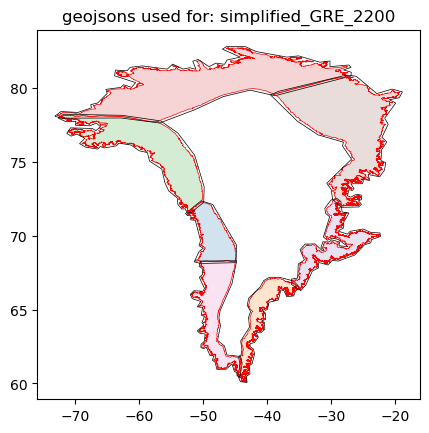

----------------------------------------------------------------
simplified_GRE_2200_CW.geojson ( 1 / 7 )
Found 98 ATL03 version 006 granules over simplified_GRE_2200_CW.geojson between 2019-05-01 and 2019-09-30.
Found 110 ATL03 version 006 granules over simplified_GRE_2200_CW.geojson between 2020-05-01 and 2020-09-30.
Found 108 ATL03 version 006 granules over simplified_GRE_2200_CW.geojson between 2021-05-01 and 2021-09-30.
Found 109 ATL03 version 006 granules over simplified_GRE_2200_CW.geojson between 2022-05-01 and 2022-09-30.
Found 107 ATL03 version 006 granules over simplified_GRE_2200_CW.geojson between 2023-05-01 and 2023-09-30.
----------------------------------------------------------------
simplified_GRE_2200_SE.geojson ( 2 / 7 )
Found 116 ATL03 version 006 granules over simplified_GRE_2200_SE.geojson between 2019-05-01 and 2019-09-30.
Found 134 ATL03 version 006 granules over simplified_GRE_2200_SE.geojson between 2020-05-01 and 2020-09-30.
Found 133 ATL03 version 006 granu

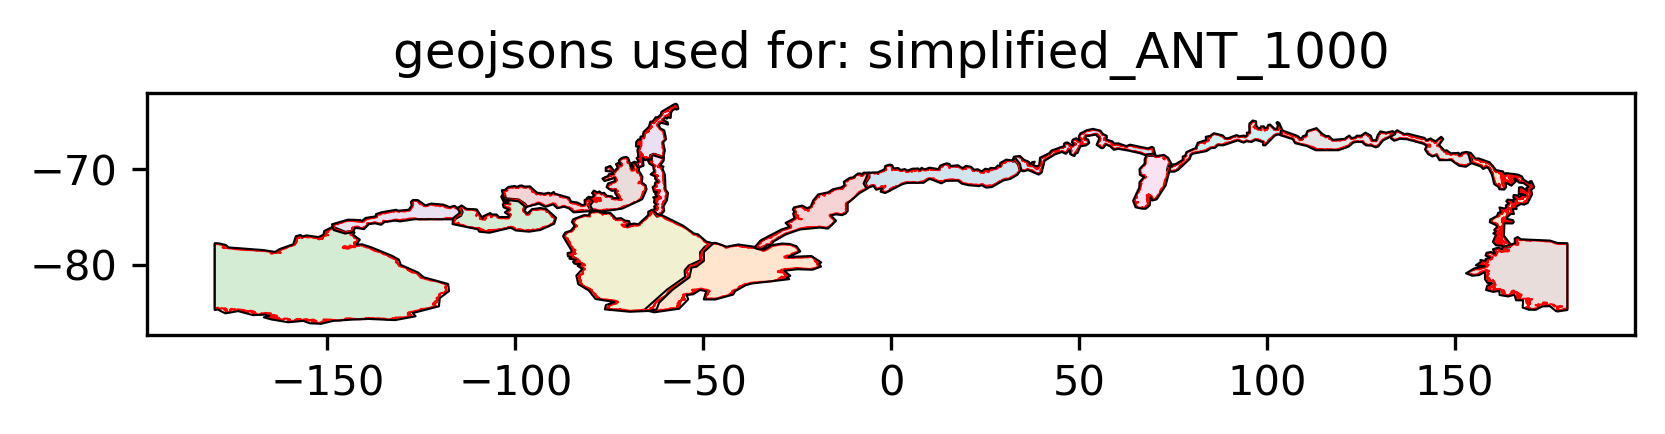

----------------------------------------------------------------
simplified_ANT_1000_East_Ap-B.geojson ( 1 / 18 )
Found 480 ATL03 version 006 granules over simplified_ANT_1000_East_Ap-B.geojson between 2018-11-01 and 2019-03-31.
Found 491 ATL03 version 006 granules over simplified_ANT_1000_East_Ap-B.geojson between 2019-11-01 and 2020-03-31.
----------------------------------------------------------------
simplified_ANT_1000_East_Jpp-K.geojson ( 2 / 18 )
Found 940 ATL03 version 006 granules over simplified_ANT_1000_East_Jpp-K.geojson between 2018-11-01 and 2019-03-31.
Found 977 ATL03 version 006 granules over simplified_ANT_1000_East_Jpp-K.geojson between 2019-11-01 and 2020-03-31.
----------------------------------------------------------------
simplified_ANT_1000_West_Ep-F.geojson ( 3 / 18 )
Found 1502 ATL03 version 006 granules over simplified_ANT_1000_West_Ep-F.geojson between 2018-11-01 and 2019-03-31.
Found 1527 ATL03 version 006 granules over simplified_ANT_1000_West_Ep-F.geojso

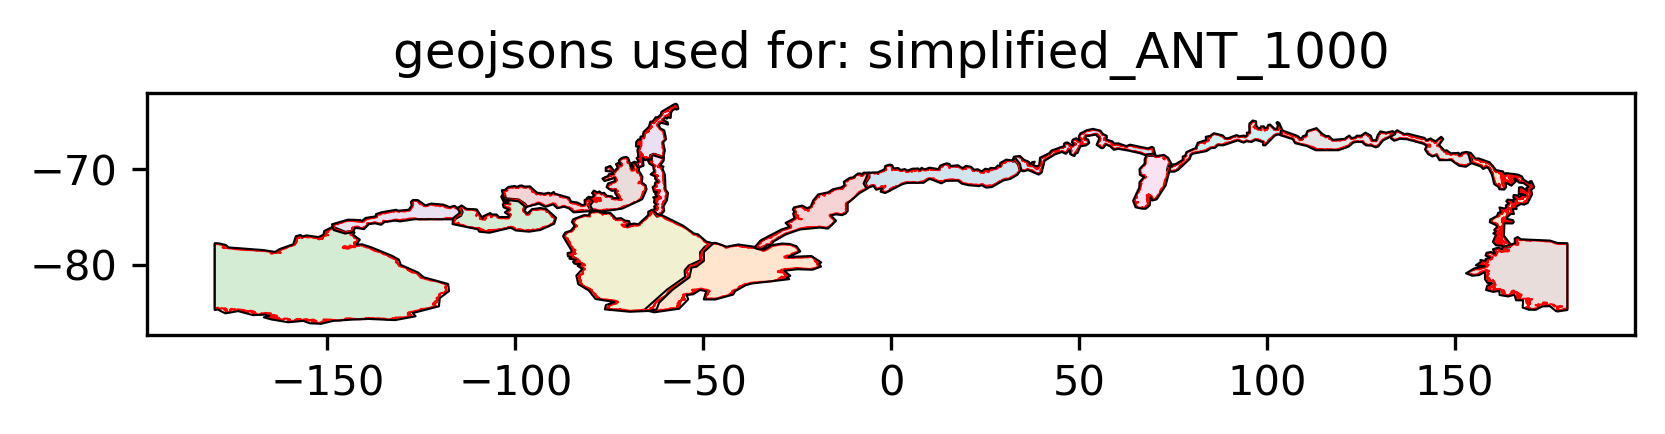

----------------------------------------------------------------
simplified_ANT_1000_East_Ap-B.geojson ( 1 / 18 )
Found 484 ATL03 version 006 granules over simplified_ANT_1000_East_Ap-B.geojson between 2020-11-01 and 2021-03-31.
Found 486 ATL03 version 006 granules over simplified_ANT_1000_East_Ap-B.geojson between 2021-11-01 and 2022-03-31.
----------------------------------------------------------------
simplified_ANT_1000_East_Jpp-K.geojson ( 2 / 18 )
Found 942 ATL03 version 006 granules over simplified_ANT_1000_East_Jpp-K.geojson between 2020-11-01 and 2021-03-31.
Found 967 ATL03 version 006 granules over simplified_ANT_1000_East_Jpp-K.geojson between 2021-11-01 and 2022-03-31.
----------------------------------------------------------------
simplified_ANT_1000_West_Ep-F.geojson ( 3 / 18 )
Found 1493 ATL03 version 006 granules over simplified_ANT_1000_West_Ep-F.geojson between 2020-11-01 and 2021-03-31.
Found 1527 ATL03 version 006 granules over simplified_ANT_1000_West_Ep-F.geojso

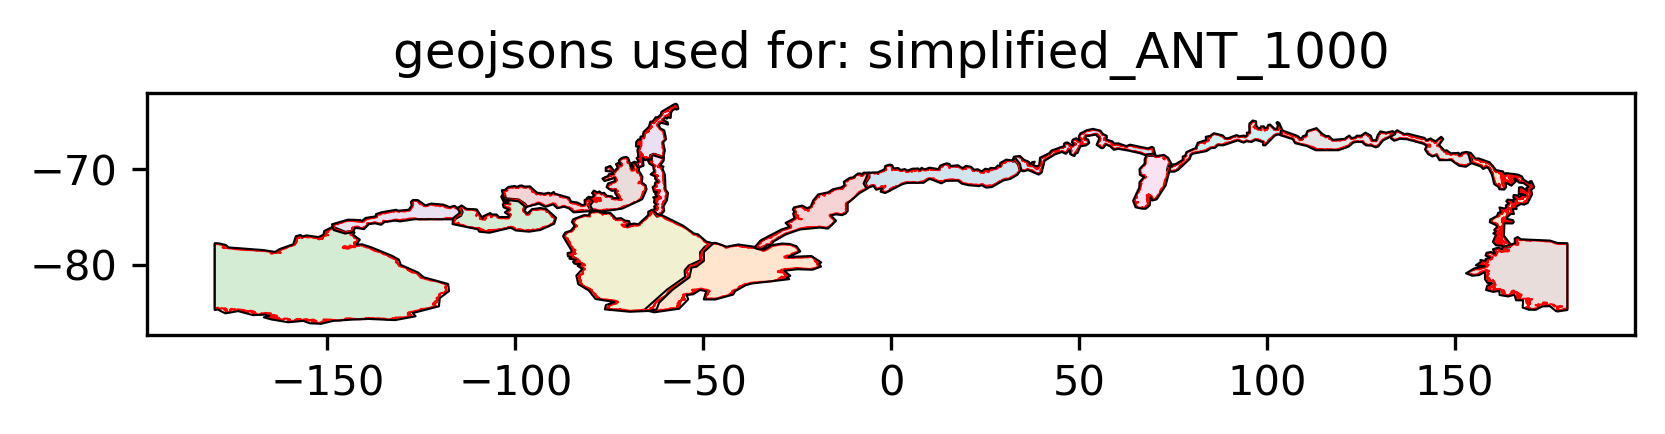

----------------------------------------------------------------
simplified_ANT_1000_East_Ap-B.geojson ( 1 / 18 )
Found 486 ATL03 version 006 granules over simplified_ANT_1000_East_Ap-B.geojson between 2022-11-01 and 2023-03-31.
----------------------------------------------------------------
simplified_ANT_1000_East_Jpp-K.geojson ( 2 / 18 )
Found 952 ATL03 version 006 granules over simplified_ANT_1000_East_Jpp-K.geojson between 2022-11-01 and 2023-03-31.
----------------------------------------------------------------
simplified_ANT_1000_West_Ep-F.geojson ( 3 / 18 )
Found 1519 ATL03 version 006 granules over simplified_ANT_1000_West_Ep-F.geojson between 2022-11-01 and 2023-03-31.
----------------------------------------------------------------
simplified_ANT_1000_East_K-A.geojson ( 4 / 18 )
Found 391 ATL03 version 006 granules over simplified_ANT_1000_East_K-A.geojson between 2022-11-01 and 2023-03-31.
----------------------------------------------------------------
simplified_ANT_100

In [5]:
############################################################
# GREENLAND - GLD3
filename_new = 'granule_lists/GLD3-GRE-0.csv'
startyear = 2019
endyear = 2023
startday = '05-01'
endday = '09-30'
icesheet = 'GrIS'

searchfor = 'simplified_GRE_2200'
gjsn_dir = 'geojsons'
gjsn_list = [gjsn_dir+'/'+f for f in os.listdir(gjsn_dir) \
            if os.path.isfile(os.path.join(gjsn_dir, f)) & (searchfor in f)]
print('____________________________________________________________________________')
print('GREENLAND 2019-23')
print('____________________________________________________________________________')

fig = plot_geojsons_for_query(searchfor, gjsn_dir='geojsons')
fig.savefig('basins/plots/query_geojsons_%s.jpg' % searchfor, dpi=300)

dflist = []
for i, gjsn in enumerate(gjsn_list):
    geojson = gjsn[gjsn.rfind('/')+1:]
    print('----------------------------------------------------------------')
    print(geojson, '(', i+1, '/', len(gjsn_list), ')')
    for yr in np.arange(startyear, endyear+1):
        start_date = '%s-%s' % (yr, startday)
        end_date = '%s-%s' % (yr, endday)
        meltseason = start_date[:4] if start_date[:4]==end_date[:4] else start_date[:4] + '-' + end_date[2:4]
        outname = 'granule_lists/' + icesheet + '_' + meltseason + '_' + geojson.replace('.geojson','') + '.csv'
        df = make_granule_list(geojson, start_date, end_date, icesheet, meltseason, outname)
        dflist.append(df)

df_all = pd.concat(dflist)
df_all.loc[:, 'description'] = df_all.apply(lambda x: x.loc['description'].replace('simplified_','').replace('GRE_','').replace('ANT_',''), axis=1)
df_all.reset_index(inplace=True, drop=True)

df_new = filter_release(df_all)
df_new.iloc[:,:5].to_csv(filename_new.replace('.csv', '_size.csv'), header=False, index=False)

print('\n___________________________________________________')
print('RESULTS:')
print('Number of ganules over Greenland:', np.sum(df_new.apply(lambda x: 'GrIS' in x.loc['description'], axis=1)))
print('Number of ganules over Antarctica:', np.sum(df_new.apply(lambda x: 'AIS' in x.loc['description'], axis=1)))
print('Total number of granules:', len(df_new))
maxrow = df_new.loc[np.argmax(df_new.size_mb),:]
print('Largest granule: %.1f GB, %s, %s' % (maxrow.size_mb/1000, maxrow.granule, maxrow.geojson))
print('Total size: %.2f TB\n' % (np.sum(df_new.size_mb)/1e6))

df_new_nosize = df_new.iloc[:,:4].copy()
df_new_nosize.to_csv(filename_new, header=False, index=False)

submit_filename = write_submit_file(filename_new, mem_gb=8)
! cat $submit_filename

dfgld_1 = df_new.copy()

############################################################
# ANTARCTICA1 - GLD3
filename_new = 'granule_lists/GLD3-ANT1-0.csv'
startyear = 2018
endyear = 2020
startday = '11-01'
endday = '03-31'
icesheet = 'AIS'

searchfor = 'simplified_ANT_1000'
gjsn_dir = 'geojsons'
gjsn_list = [gjsn_dir+'/'+f for f in os.listdir(gjsn_dir) \
            if os.path.isfile(os.path.join(gjsn_dir, f)) & (searchfor in f)]
print('____________________________________________________________________________')
print('ANTARCTICA1 - GLD3 (2018-19 to 2019-20)')
print('____________________________________________________________________________')

fig = plot_geojsons_for_query(searchfor, gjsn_dir='geojsons')
fig.savefig('basins/plots/query_geojsons_%s.jpg' % searchfor, dpi=300)

dflist = []
for i, gjsn in enumerate(gjsn_list):
    geojson = gjsn[gjsn.rfind('/')+1:]
    print('----------------------------------------------------------------')
    print(geojson, '(', i+1, '/', len(gjsn_list), ')')
    for yr in np.arange(startyear, endyear):
        start_date = '%s-%s' % (yr, startday)
        end_date = '%s-%s' % (yr+1, endday)
        meltseason = start_date[:4] if start_date[:4]==end_date[:4] else start_date[:4] + '-' + end_date[2:4]
        outname = 'granule_lists/' + icesheet + '_' + meltseason + '_' + geojson.replace('.geojson','') + '.csv'
        df = make_granule_list(geojson, start_date, end_date, icesheet, meltseason, outname)
        dflist.append(df)

df_all = pd.concat(dflist)
df_all.loc[:, 'description'] = df_all.apply(lambda x: x.loc['description'].replace('simplified_','').replace('GRE_','').replace('ANT_',''), axis=1)
df_all.reset_index(inplace=True, drop=True)

df_new = filter_release(df_all)
df_new.iloc[:,:5].to_csv(filename_new.replace('.csv', '_size.csv'), header=False, index=False)

print('\n___________________________________________________')
print('RESULTS:')
print('Number of ganules over Greenland:', np.sum(df_new.apply(lambda x: 'GrIS' in x.loc['description'], axis=1)))
print('Number of ganules over Antarctica:', np.sum(df_new.apply(lambda x: 'AIS' in x.loc['description'], axis=1)))
print('Total number of granules:', len(df_new))
maxrow = df_new.loc[np.argmax(df_new.size_mb),:]
print('Largest granule: %.1f GB, %s, %s' % (maxrow.size_mb/1000, maxrow.granule, maxrow.geojson))
print('Total size: %.2f TB\n' % (np.sum(df_new.size_mb)/1e6))

df_new_nosize = df_new.iloc[:,:4].copy()
df_new_nosize.to_csv(filename_new, header=False, index=False)

submit_filename = write_submit_file(filename_new, mem_gb=8)
! cat $submit_filename

dfgld_2 = df_new.copy()

############################################################
# ANTARCTICA2 - GLD3
filename_new = 'granule_lists/GLD3-ANT2-0.csv'
startyear = 2020
endyear = 2022
startday = '11-01'
endday = '03-31'
icesheet = 'AIS'

searchfor = 'simplified_ANT_1000'
gjsn_dir = 'geojsons'
gjsn_list = [gjsn_dir+'/'+f for f in os.listdir(gjsn_dir) \
            if os.path.isfile(os.path.join(gjsn_dir, f)) & (searchfor in f)]
print('____________________________________________________________________________')
print('ANTARCTICA2 - GLD3 (2020-21 to 2021-22)')
print('____________________________________________________________________________')

fig = plot_geojsons_for_query(searchfor, gjsn_dir='geojsons')
fig.savefig('basins/plots/query_geojsons_%s.jpg' % searchfor, dpi=300)

dflist = []
for i, gjsn in enumerate(gjsn_list):
    geojson = gjsn[gjsn.rfind('/')+1:]
    print('----------------------------------------------------------------')
    print(geojson, '(', i+1, '/', len(gjsn_list), ')')
    for yr in np.arange(startyear, endyear):
        start_date = '%s-%s' % (yr, startday)
        end_date = '%s-%s' % (yr+1, endday)
        meltseason = start_date[:4] if start_date[:4]==end_date[:4] else start_date[:4] + '-' + end_date[2:4]
        outname = 'granule_lists/' + icesheet + '_' + meltseason + '_' + geojson.replace('.geojson','') + '.csv'
        df = make_granule_list(geojson, start_date, end_date, icesheet, meltseason, outname)
        dflist.append(df)

df_all = pd.concat(dflist)
df_all.loc[:, 'description'] = df_all.apply(lambda x: x.loc['description'].replace('simplified_','').replace('GRE_','').replace('ANT_',''), axis=1)
df_all.reset_index(inplace=True, drop=True)

df_new = filter_release(df_all)
df_new.iloc[:,:5].to_csv(filename_new.replace('.csv', '_size.csv'), header=False, index=False)

print('\n___________________________________________________')
print('RESULTS:')
print('Number of ganules over Greenland:', np.sum(df_new.apply(lambda x: 'GrIS' in x.loc['description'], axis=1)))
print('Number of ganules over Antarctica:', np.sum(df_new.apply(lambda x: 'AIS' in x.loc['description'], axis=1)))
print('Total number of granules:', len(df_new))
maxrow = df_new.loc[np.argmax(df_new.size_mb),:]
print('Largest granule: %.1f GB, %s, %s' % (maxrow.size_mb/1000, maxrow.granule, maxrow.geojson))
print('Total size: %.2f TB\n' % (np.sum(df_new.size_mb)/1e6))

df_new_nosize = df_new.iloc[:,:4].copy()
df_new_nosize.to_csv(filename_new, header=False, index=False)

submit_filename = write_submit_file(filename_new, mem_gb=8)
! cat $submit_filename

dfgld_3 = df_new.copy()

############################################################
# ANTARCTICA3 - GLD3
filename_new = 'granule_lists/GLD3-ANT3-0.csv'
startyear = 2022
endyear = 2023
startday = '11-01'
endday = '03-31'
icesheet = 'AIS'

searchfor = 'simplified_ANT_1000'
gjsn_dir = 'geojsons'
gjsn_list = [gjsn_dir+'/'+f for f in os.listdir(gjsn_dir) \
            if os.path.isfile(os.path.join(gjsn_dir, f)) & (searchfor in f)]
print('____________________________________________________________________________')
print('ANTARCTICA3 - GLD3 (2022-23)')
print('____________________________________________________________________________')

fig = plot_geojsons_for_query(searchfor, gjsn_dir='geojsons')
fig.savefig('basins/plots/query_geojsons_%s.jpg' % searchfor, dpi=300)

dflist = []
for i, gjsn in enumerate(gjsn_list):
    geojson = gjsn[gjsn.rfind('/')+1:]
    print('----------------------------------------------------------------')
    print(geojson, '(', i+1, '/', len(gjsn_list), ')')
    for yr in np.arange(startyear, endyear):
        start_date = '%s-%s' % (yr, startday)
        end_date = '%s-%s' % (yr+1, endday)
        meltseason = start_date[:4] if start_date[:4]==end_date[:4] else start_date[:4] + '-' + end_date[2:4]
        outname = 'granule_lists/' + icesheet + '_' + meltseason + '_' + geojson.replace('.geojson','') + '.csv'
        df = make_granule_list(geojson, start_date, end_date, icesheet, meltseason, outname)
        dflist.append(df)

df_all = pd.concat(dflist)
df_all.loc[:, 'description'] = df_all.apply(lambda x: x.loc['description'].replace('simplified_','').replace('GRE_','').replace('ANT_',''), axis=1)
df_all.reset_index(inplace=True, drop=True)

df_new = filter_release(df_all)
df_new.iloc[:,:5].to_csv(filename_new.replace('.csv', '_size.csv'), header=False, index=False)

print('\n___________________________________________________')
print('RESULTS:')
print('Number of ganules over Greenland:', np.sum(df_new.apply(lambda x: 'GrIS' in x.loc['description'], axis=1)))
print('Number of ganules over Antarctica:', np.sum(df_new.apply(lambda x: 'AIS' in x.loc['description'], axis=1)))
print('Total number of granules:', len(df_new))
maxrow = df_new.loc[np.argmax(df_new.size_mb),:]
print('Largest granule: %.1f GB, %s, %s' % (maxrow.size_mb/1000, maxrow.granule, maxrow.geojson))
print('Total size: %.2f TB\n' % (np.sum(df_new.size_mb)/1e6))

df_new_nosize = df_new.iloc[:,:4].copy()
df_new_nosize.to_csv(filename_new, header=False, index=False)

submit_filename = write_submit_file(filename_new, mem_gb=8)
! cat $submit_filename

dfgld_4 = df_new.copy()

###################################################################
# get all the data together and print stats
filename_new = 'granule_lists/GLD3-ALLDATA-0.csv'

dfsgld3 = pd.concat((dfgld_1, dfgld_2, dfgld_3, dfgld_4)).reset_index(drop=True)
df_new = dfsgld3.copy()

df_new.iloc[:,:5].to_csv(filename_new.replace('.csv', '_size.csv'), header=False, index=False)

print('\n___________________________________________________')
print('RESULTS FOR ALL DATA:')
print('Number of ganules over Greenland:', np.sum(df_new.apply(lambda x: 'GrIS' in x.loc['description'], axis=1)))
print('Number of ganules over Antarctica:', np.sum(df_new.apply(lambda x: 'AIS' in x.loc['description'], axis=1)))
print('Total number of granules:', len(df_new))
maxrow = df_new.loc[np.argmax(df_new.size_mb),:]
print('Largest granule: %.1f GB, %s, %s' % (maxrow.size_mb/1000, maxrow.granule, maxrow.geojson))
print('Total size: %.2f TB\n' % (np.sum(df_new.size_mb)/1e6))

df_new_nosize = df_new.iloc[:,:4].copy()
df_new_nosize.to_csv(filename_new, header=False, index=False)

In [6]:
# df_new.to_csv(filename_new.replace('.csv', '_size.csv'), header=False, index=False)

In [7]:
df_new

,granule,geojson,description,geojson_clip,size_mb,release,version,ttttccnn,granule_region_id,select
0,ATL03_20190502090550_05210303_006_02.h5,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2019_2200_CW,geojsons/GRE_2200_CW.geojson,4374.874860,2,6,5210303,5210303geojsons/GRE_2200_CW.geojson,True
1,ATL03_20190502215043_05290305_006_02.h5,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2019_2200_CW,geojsons/GRE_2200_CW.geojson,2634.167777,2,6,5290305,5290305geojsons/GRE_2200_CW.geojson,True
2,ATL03_20190503084011_05360303_006_02.h5,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2019_2200_CW,geojsons/GRE_2200_CW.geojson,2209.120083,2,6,5360303,5360303geojsons/GRE_2200_CW.geojson,True
3,ATL03_20190503212504_05440305_006_02.h5,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2019_2200_CW,geojsons/GRE_2200_CW.geojson,2171.890388,2,6,5440305,5440305geojsons/GRE_2200_CW.geojson,True
4,ATL03_20190507083151_05970303_006_02.h5,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2019_2200_CW,geojsons/GRE_2200_CW.geojson,2498.196455,2,6,5970303,5970303geojsons/GRE_2200_CW.geojson,True
...,...,...,...,...,...,...,...,...,...,...
54051,ATL03_20230330012229_01321912_006_02.h5,geojsons/simplified_ANT_1000_East_Cp-D.geojson,AIS_2022-23_1000_East_Cp-D,geojsons/ANT_1000_East_Cp-D.geojson,2422.657138,2,6,1321912,1321912geojsons/ANT_1000_East_Cp-D.geojson,True
54052,ATL03_20230330025646_01331912_006_02.h5,geojsons/simplified_ANT_1000_East_Cp-D.geojson,AIS_2022-23_1000_East_Cp-D,geojsons/ANT_1000_East_Cp-D.geojson,2409.214574,2,6,1331912,1331912geojsons/ANT_1000_East_Cp-D.geojson,True
54053,ATL03_20230330134324_01401910_006_02.h5,geojsons/simplified_ANT_1000_East_Cp-D.geojson,AIS_2022-23_1000_East_Cp-D,geojsons/ANT_1000_East_Cp-D.geojson,736.194994,2,6,1401910,1401910geojsons/ANT_1000_East_Cp-D.geojson,True
54054,ATL03_20230331023113_01481912_006_02.h5,geojsons/simplified_ANT_1000_East_Cp-D.geojson,AIS_2022-23_1000_East_Cp-D,geojsons/ANT_1000_East_Cp-D.geojson,2065.255200,2,6,1481912,1481912geojsons/ANT_1000_East_Cp-D.geojson,True


# Greenland 2023 Test GLD3
with up to 2200 m and floating ice added from GRIMP ice mask

In [ ]:
filename_new = 'granule_lists/GRE_2200_2023_test.csv'
startyear = 2023
endyear = 2023
startday = '05-01'
endday = '09-30'
icesheet = 'GrIS'

searchfor = 'simplified_GRE_2200'
gjsn_dir = 'geojsons'
gjsn_list = [gjsn_dir+'/'+f for f in os.listdir(gjsn_dir) \
            if os.path.isfile(os.path.join(gjsn_dir, f)) & (searchfor in f)]
print('____________________________________________________________________________')
print('GREENLAND 2023')
print('____________________________________________________________________________')

fig = plot_geojsons_for_query(searchfor, gjsn_dir='geojsons')
fig.savefig('basins/plots/query_geojsons_%s.jpg' % searchfor, dpi=300)

dflist = []
for i, gjsn in enumerate(gjsn_list):
    geojson = gjsn[gjsn.rfind('/')+1:]
    print('----------------------------------------------------------------')
    print(geojson, '(', i+1, '/', len(gjsn_list), ')')
    for yr in np.arange(startyear, endyear+1):
        start_date = '%s-%s' % (yr, startday)
        end_date = '%s-%s' % (yr, endday)
        meltseason = start_date[:4] if start_date[:4]==end_date[:4] else start_date[:4] + '-' + end_date[2:4]
        outname = 'granule_lists/' + icesheet + '_' + meltseason + '_' + geojson.replace('.geojson','') + '.csv'
        df = make_granule_list(geojson, start_date, end_date, icesheet, meltseason, outname)
        dflist.append(df)

df_all = pd.concat(dflist)
df_all.loc[:, 'description'] = df_all.apply(lambda x: x.loc['description'].replace('simplified_','').replace('GRE_','').replace('ANT_',''), axis=1)
df_all.reset_index(inplace=True, drop=True)

df_new = filter_release(df_all)
df_new.iloc[:,:5].to_csv(filename_new.replace('.csv', '_size.csv'), header=False, index=False)

print('\n___________________________________________________')
print('RESULTS:')
print('Number of ganules over Greenland:', np.sum(df_new.apply(lambda x: 'GrIS' in x.loc['description'], axis=1)))
print('Number of ganules over Antarctica:', np.sum(df_new.apply(lambda x: 'AIS' in x.loc['description'], axis=1)))
print('Total number of granules:', len(df_new))
maxrow = df_new.loc[np.argmax(df_new.size_mb),:]
print('Largest granule: %.1f GB, %s, %s' % (maxrow.size_mb/1000, maxrow.granule, maxrow.geojson))
print('Total size: %.2f TB\n' % (np.sum(df_new.size_mb)/1e6))

df_new_nosize = df_new.iloc[:,:4].copy()
df_new_nosize.to_csv(filename_new, header=False, index=False)

submit_filename = write_submit_file(filename_new, mem_gb=16)
! cat $submit_filename

In [ ]:
# searchfor = 'simplified_ANT_1000'
# fig = plot_geojsons_for_query(searchfor, gjsn_dir='geojsons')
# fig.savefig('basins/plots/query_geojsons_%s.jpg' % searchfor, dpi=300)

In [ ]:
nms = ['granule', 'geojson', 'description', 'geojson_clip']
df_check = pd.read_csv('granule_lists/GRE_2000_May2023_Sep2023_newdata.csv', header=None, names=nms)
df_check

In [ ]:
nms = ['granule', 'geojson', 'description', 'geojson_clip']
df = pd.read_csv('granule_lists/GRE_2000_May2023_Sep2023_newdata.csv', header=None, names=nms)
dfg = df[df.apply(lambda x: (x.granule[6:14] == '20230806'), axis=1)]
# dfg.to_csv('granule_lists/newdata_gre-2023_test-15.csv', header=False, index=False)
dfg = dfg[dfg.apply(lambda x: (('SW' in x.geojson) | ('CW' in x.geojson)) & ('0719' in x.granule), axis=1)]
dfg.to_csv('granule_lists/newdata_gre-2023_test-2.csv', header=False, index=False)
dfg

In [ ]:
# # function to convert shapefile to geojson - if needed
# shp2geojson_nsidc('shapefiles/jakobshavn_small.shp')

lons = [-154, -153]
lats = [-85.46, -85.41]

coords = [(lons[x[0]], lats[x[1]]) for x in [(0,0), (1,0), (1,1), (0,1), (0,0)]]
poly = Polygon(coords)
gdf = gpd.GeoDataFrame(geometry=[poly], crs='EPSG:4326') 
fn_gjsn = 'geojsons/test_ross.geojson'
gdf.to_file(fn_gjsn, driver='GeoJSON')
outname_list = fn_gjsn.split('/')[-1].replace('.geojson','.csv')

# Greenland 2023 (new data only)

In [ ]:
filename_new = 'granule_lists/GRE_2000_May2023_Sep2023_newdata.csv'
filename_all = 'granule_lists/alldata_2018-2023.csv'

startyear = 2023
endyear = 2023
startday = '05-01'
endday = '09-30'
icesheet = 'GrIS'

searchfor = 'simplified_GRE_2000'
gjsn_dir = 'geojsons'
gjsn_list = [gjsn_dir+'/'+f for f in os.listdir(gjsn_dir) \
            if os.path.isfile(os.path.join(gjsn_dir, f)) & (searchfor in f)]
print('____________________________________________________________________________')
print('GREENLAND 2023')
print('____________________________________________________________________________')

dflist = []
for i, gjsn in enumerate(gjsn_list):
    geojson = gjsn[gjsn.rfind('/')+1:]
    print('----------------------------------------------------------------')
    print(geojson, '(', i+1, '/', len(gjsn_list), ')')
    for yr in np.arange(startyear, endyear+1):
        start_date = '%s-%s' % (yr, startday)
        end_date = '%s-%s' % (yr, endday)
        meltseason = start_date[:4] if start_date[:4]==end_date[:4] else start_date[:4] + '-' + end_date[2:4]
        outname = 'granule_lists/' + icesheet + '_' + meltseason + '_' + geojson.replace('.geojson','') + '.csv'
        df = make_granule_list(geojson, start_date, end_date, icesheet, meltseason, outname)
        dflist.append(df)

df_all = pd.concat(dflist)
df_all.loc[:, 'description'] = df_all.apply(lambda x: x.loc['description'].replace('simplified_','').replace('GRE_','').replace('ANT_',''), axis=1)
df_all.reset_index(inplace=True, drop=True)

def filter_release(df):
    # there should not be any, but to make sure drop any duplicates
    df = df.drop_duplicates(ignore_index=True)
    
    # keep only the latest release of each granule (relevant during ITRF reprocessing, etc.)
    df['release'] = df.apply(lambda x: int(x.granule.split('_')[-1][:2]), axis=1)
    df['version'] = df.apply(lambda x: int(x.granule.split('_')[3]), axis=1)
    df['ttttccnn'] = df.apply(lambda x: int(x.granule.split('_')[2]), axis=1)
    
    # make id for granule / region combination
    df['granule_region_id'] = df.apply(lambda x: str(x.ttttccnn) + x.geojson_clip, axis=1)
    df_maxversion = df.groupby(by='granule_region_id')[['version']].max().rename(columns={'version': 'version_max'})
    df['select'] = df.apply(lambda x: x.version == df_maxversion.loc[x.granule_region_id].version_max, axis=1)
    df = df[df.select]
    df_maxrelease = df.groupby(by='granule_region_id')[['release']].max().rename(columns={'release': 'release_max'})
    df['select'] = df.apply(lambda x: x.release == df_maxrelease.loc[x.granule_region_id].release_max, axis=1)
    df = df[df.select]

    return df

# get the granules that have already been procesed
in_list = [
    'granule_lists/GRE_2000_May2019_Jun2023.csv',
    'granule_lists/ANT_1000_Dec2018_Mar2021.csv',
    'granule_lists/ANT_1000_Dec2021_Mar2023.csv',
    'granule_lists/extra_shoulderseason_GRE_2000_ANT_1000.csv']
nms = ['granule', 'geojson', 'description', 'geojson_clip', 'size_mb']
dfs_all_input = []
for grlist in in_list:
    dfs_all_input.append(pd.read_csv(grlist.replace('.csv', '_size.csv'), header=None, names=nms))
df_processed = pd.concat(dfs_all_input).reset_index(drop=True)
df_already_run = filter_release(df_processed)

df_new = filter_release(df_all)
ids_run_already = list(df_already_run.granule_region_id)
df_new['select'] = df_new.apply(lambda x: x.granule_region_id not in ids_run_already, axis=1)
df_new = df_new[df_new.select].reset_index(drop=True)
df_new.iloc[:,:5]
df_new.iloc[:,:5].to_csv(filename_new.replace('.csv', '_size.csv'), header=False, index=False)

print('Number of ganules over Greenland:', np.sum(df_new.apply(lambda x: 'GrIS' in x.loc['description'], axis=1)))
print('Number of ganules over Antarctica:', np.sum(df_new.apply(lambda x: 'AIS' in x.loc['description'], axis=1)))
print('Total number of granules:', len(df_new))
maxrow = df_new.loc[np.argmax(df_new.size_mb),:]
print('Largest granule: %.1f GB, %s, %s' % (maxrow.size_mb/1000, maxrow.granule, maxrow.geojson))
print('Total size: %.2f TB' % (np.sum(df_new.size_mb)/1e6))

df_new_nosize = df_new.iloc[:,:4].copy()
df_new_nosize.to_csv(filename_new, header=False, index=False)

print('____________________________________________________________________________')
print('ALL DATA COMBINED')
df_everything = pd.concat((df_new, df_already_run)).drop_duplicates(ignore_index=True, subset=['granule_region_id']).sort_values(by='granule').reset_index(drop=True)
print('Number of ganules over Greenland:', np.sum(df_everything.apply(lambda x: 'GrIS' in x.loc['description'], axis=1)))
print('Number of ganules over Antarctica:', np.sum(df_everything.apply(lambda x: 'AIS' in x.loc['description'], axis=1)))
print('Total number of granules:', len(df_everything))
maxrow = df_everything.loc[np.argmax(df_everything.size_mb),:]
print('Largest granule: %.1f GB, %s, %s' % (maxrow.size_mb/1000, maxrow.granule, maxrow.geojson))
print('Total size: %.2f TB' % (np.sum(df_everything.size_mb)/1e6))

df_everything.iloc[:,:5].to_csv(filename_all.replace('.csv', '_size.csv'), header=False, index=False)
df_everything_nosize = df_everything.iloc[:,:4].copy()
df_everything_nosize.to_csv(filename_all, header=False, index=False)

In [ ]:
def filter_release(df):
    # there should not be any, but to make sure drop any duplicates
    df = df.drop_duplicates(ignore_index=True)
    
    # keep only the latest release of each granule (relevant during ITRF reprocessing, etc.)
    df['release'] = df.apply(lambda x: int(x.granule.split('_')[-1][:2]), axis=1)
    df['version'] = df.apply(lambda x: int(x.granule.split('_')[3]), axis=1)
    df['ttttccnn'] = df.apply(lambda x: int(x.granule.split('_')[2]), axis=1)
    
    # make id for granule / region combination
    df['granule_region_id'] = df.apply(lambda x: str(x.ttttccnn) + x.geojson_clip, axis=1)
    df_maxversion = df.groupby(by='granule_region_id')[['version']].max().rename(columns={'version': 'version_max'})
    df['select'] = df.apply(lambda x: x.version == df_maxversion.loc[x.granule_region_id].version_max, axis=1)
    df = df[df.select]
    df_maxrelease = df.groupby(by='granule_region_id')[['release']].max().rename(columns={'release': 'release_max'})
    df['select'] = df.apply(lambda x: x.release == df_maxrelease.loc[x.granule_region_id].release_max, axis=1)
    df = df[df.select]

    return df

In [ ]:
# get the granules that have already been procesed
in_list = [
    'granule_lists/GRE_2000_May2019_Jun2023.csv',
    'granule_lists/ANT_1000_Dec2018_Mar2021.csv',
    'granule_lists/ANT_1000_Dec2021_Mar2023.csv',
    'granule_lists/extra_shoulderseason_GRE_2000_ANT_1000.csv']
nms = ['granule', 'geojson', 'description', 'geojson_clip', 'size_mb']
dfs_all_input = []
for grlist in in_list:
    dfs_all_input.append(pd.read_csv(grlist.replace('.csv', '_size.csv'), header=None, names=nms))
df_processed = pd.concat(dfs_all_input).reset_index(drop=True)
df_already_run = filter_release(df_processed)

In [ ]:
# counts = df_already_run.groupby('granule_region_id')[['granule']].count().rename(columns={'granule': 'counts'})
# counts = counts[counts.counts > 1]
# for i in range(len(counts)):
#     thisdf = df_already_run[df_already_run.granule_region_id == list(counts.index)[0]]
#     print(' ')
#     for j in range(len(thisdf)):
#         x = thisdf.iloc[j]
#         print(x.granule, x.geojson, x.description)

In [ ]:
filename_out = 'granule_lists/GRE_2000_May2023_Sep2023_newdata.csv'

df_new = filter_release(df_all)
ids_run_already = list(df_already_run.granule_region_id)
df_new['select'] = df_new.apply(lambda x: x.granule_region_id not in ids_run_already, axis=1)
df_new = df_new[df_new.select].reset_index(drop=True)
df_new.iloc[:,:5]
df_new.iloc[:,:5].to_csv(filename_out.replace('.csv', '_size.csv'), header=False, index=False)

print('Number of ganules over Greenland:', np.sum(df_new.apply(lambda x: 'GrIS' in x.loc['description'], axis=1)))
print('Number of ganules over Antarctica:', np.sum(df_new.apply(lambda x: 'AIS' in x.loc['description'], axis=1)))
print('Total number of granules:', len(df_new))
maxrow = df_new.loc[np.argmax(df_new.size_mb),:]
print('Largest granule: %.1f GB, %s, %s' % (maxrow.size_mb/1000, maxrow.granule, maxrow.geojson))
print('Total size: %.2f TB' % (np.sum(df_new.size_mb)/1e6))

df_new_nosize = df_new.iloc[:,:4].copy()
df_new_nosize.to_csv(filename_out, header=False, index=False)

filename_all = 'granule_lists/alldata_2018-2023.csv'
df_everything = pd.concat((df_new, df_already_run)).drop_duplicates(ignore_index=True, subset=['granule_region_id']).sort_values(by='granule').reset_index(drop=True)
print('Number of ganules over Greenland:', np.sum(df_everything.apply(lambda x: 'GrIS' in x.loc['description'], axis=1)))
print('Number of ganules over Antarctica:', np.sum(df_everything.apply(lambda x: 'AIS' in x.loc['description'], axis=1)))
print('Total number of granules:', len(df_everything))
maxrow = df_everything.loc[np.argmax(df_everything.size_mb),:]
print('Largest granule: %.1f GB, %s, %s' % (maxrow.size_mb/1000, maxrow.granule, maxrow.geojson))
print('Total size: %.2f TB' % (np.sum(df_everything.size_mb)/1e6))

df_everything.iloc[:,:5].to_csv(filename_all.replace('.csv', '_size.csv'), header=False, index=False)
df_everything_nosize = df_everything.iloc[:,:4].copy()
df_everything_nosize.to_csv(filename_all, header=False, index=False)
df_everything_nosize

In [ ]:
filename_all = 'granule_lists/alldata_2018-2023.csv'
df_everything = pd.concat((df_new, df_already_run)).drop_duplicates(ignore_index=True, subset=['granule_region_id']).sort_values(by='granule').reset_index(drop=True)
print('Number of ganules over Greenland:', np.sum(df_everything.apply(lambda x: 'GrIS' in x.loc['description'], axis=1)))
print('Number of ganules over Antarctica:', np.sum(df_everything.apply(lambda x: 'AIS' in x.loc['description'], axis=1)))
print('Total number of granules:', len(df_everything))
maxrow = df_everything.loc[np.argmax(df_everything.size_mb),:]
print('Largest granule: %.1f GB, %s, %s' % (maxrow.size_mb/1000, maxrow.granule, maxrow.geojson))
print('Total size: %.2f TB' % (np.sum(df_everything.size_mb)/1e6))

df_everything.iloc[:,:5].to_csv(filename_all.replace('.csv', '_size.csv'), header=False, index=False)
df_everything_nosize = df_everything.iloc[:,:4].copy()
df_everything_nosize.to_csv(filename_all, header=False, index=False)
df_everything_nosize

In [ ]:
print(len(df_already_run.granule_region_id), len(np.unique(df_already_run.granule_region_id)))

In [ ]:
'272005geojsons/GRE_2000_NO.geojson' in list(df_already_run.granule_region_id)

In [ ]:
ids_run_already = list(df_already_run.granule_region_id)
df_new['select'] = df_new.apply(lambda x: x.granule_region_id not in ids_run_already, axis=1)
print(np.sum(df_new.select))
df_already_run
df_new

In [ ]:
df_already_run.sort_values(by='granule')

In [ ]:
df_already_run.apply(lambda x: x.granule[6:14], axis=1)

In [ ]:
dfnewall = df_all.copy()
dfnewall['granule_norelease'] = dfnewall.apply(lambda x: x.granule[:x.granule.rfind('_')], axis=1)
dfnewall['release'] = dfnewall.apply(lambda x: int(x.granule.split('_')[-1][:2]), axis=1)
print(len(np.unique(dfnewall.granule_norelease)), len(np.unique(dfnewall.granule)), len(dfnewall))

print(dfnewall.groupby(by='release')['granule'].count())
dfnewall

In [ ]:
np.sum(df.select)

# Greenland 2019 - June 2023

In [ ]:
dflist = []
filename_out = 'granule_lists/GRE_2000_May2019_Jun2023.csv'

startyear = 2019
endyear = 2023
startday = '05-15'
endday = '09-15'
icesheet = 'GrIS'

searchfor = 'simplified_GRE_2000'
gjsn_dir = 'geojsons'
gjsn_list = [gjsn_dir+'/'+f for f in os.listdir(gjsn_dir) \
            if os.path.isfile(os.path.join(gjsn_dir, f)) & (searchfor in f)]
print('____________________________________________________________________________')
print('GREENLAND')
print('____________________________________________________________________________')

for i, gjsn in enumerate(gjsn_list):
    geojson = gjsn[gjsn.rfind('/')+1:]
    print('----------------------------------------------------------------')
    print(geojson, '(', i+1, '/', len(gjsn_list), ')')
    for yr in np.arange(startyear, endyear+1):
        start_date = '%s-%s' % (yr, startday)
        end_date = '%s-%s' % (yr, endday)
        meltseason = start_date[:4] if start_date[:4]==end_date[:4] else start_date[:4] + '-' + end_date[2:4]
        outname = 'granule_lists/' + icesheet + '_' + meltseason + '_' + geojson.replace('.geojson','') + '.csv'
        df = make_granule_list(geojson, start_date, end_date, icesheet, meltseason, outname)
        dflist.append(df)

df_all = pd.concat(dflist)
df_all.loc[:, 'description'] = df_all.apply(lambda x: x.loc['description'].replace('simplified_','').replace('GRE_','').replace('ANT_',''), axis=1)
df_all.reset_index(inplace=True, drop=True)
df_all.to_csv(filename_out.replace('.csv', '_size.csv'), header=False, index=False)

print('Number of ganules over Greenland:', np.sum(df_all.apply(lambda x: 'GrIS' in x.loc['description'], axis=1)))
print('Number of ganules over Antarctica:', np.sum(df_all.apply(lambda x: 'AIS' in x.loc['description'], axis=1)))
print('Total number of granules:', len(df_all))
maxrow = df_all.loc[np.argmax(df_all.size_mb),:]
print('Largest granule: %.1f GB, %s, %s' % (maxrow.size_mb/1000, maxrow.granule, maxrow.geojson))
print('Total size: %.2f TB' % (np.sum(df_all.size_mb)/1e6))

df_all_nosize = df_all.drop(columns='size_mb').copy()
df_all_nosize.to_csv(filename_out, header=False, index=False)
df_all_nosize

# Antarctica 2018/19 - 2020/21

In [ ]:
dflist = []
filename_out = 'granule_lists/ANT_1000_Dec2018_Mar2021.csv'

startyear = 2018
endyear = 2021
startday = '12-01'
endday = '03-01'
icesheet = 'AIS'

searchfor = 'simplified_ANT_1000'
gjsn_dir = 'geojsons'
gjsn_list = [gjsn_dir+'/'+f for f in os.listdir(gjsn_dir) \
            if os.path.isfile(os.path.join(gjsn_dir, f)) & (searchfor in f)]

print('____________________________________________________________________________')
print('ANTARCTICA 2018/19 - 2020/21')
print('____________________________________________________________________________')
for i, gjsn in enumerate(gjsn_list):
    geojson = gjsn[gjsn.rfind('/')+1:]
    print('----------------------------------------------------------------')
    print(geojson, '(', i+1, '/', len(gjsn_list), ')')
    for yr in np.arange(startyear, endyear):
        start_date = '%s-%s' % (yr, startday)
        end_date = '%s-%s' % (yr+1, endday)
        meltseason = start_date[:4] if start_date[:4]==end_date[:4] else start_date[:4] + '-' + end_date[2:4]
        outname = 'granule_lists/' + icesheet + '_' + meltseason + '_' + geojson.replace('.geojson','') + '.csv'
        df = make_granule_list(geojson, start_date, end_date, icesheet, meltseason, outname)
        dflist.append(df)

df_all = pd.concat(dflist)
df_all.loc[:, 'description'] = df_all.apply(lambda x: x.loc['description'].replace('simplified_','').replace('GRE_','').replace('ANT_',''), axis=1)
df_all.reset_index(inplace=True, drop=True)
df_all.to_csv(filename_out.replace('.csv', '_size.csv'), header=False, index=False)

print('Number of ganules over Greenland:', np.sum(df_all.apply(lambda x: 'GrIS' in x.loc['description'], axis=1)))
print('Number of ganules over Antarctica:', np.sum(df_all.apply(lambda x: 'AIS' in x.loc['description'], axis=1)))
print('Total number of granules:', len(df_all))
maxrow = df_all.loc[np.argmax(df_all.size_mb),:]
print('Largest granule: %.1f GB, %s, %s' % (maxrow.size_mb/1000, maxrow.granule, maxrow.geojson))
print('Total size: %.2f TB' % (np.sum(df_all.size_mb)/1e6))

df_all_nosize = df_all.drop(columns='size_mb').copy()
df_all_nosize.to_csv(filename_out, header=False, index=False)
df_all_nosize

# Antarctica 2021/22 - 2022/23

In [ ]:
dflist = []
filename_out = 'granule_lists/ANT_1000_Dec2021_Mar2023.csv'

startyear = 2021
endyear = 2023
startday = '12-01'
endday = '03-01'
icesheet = 'AIS'

searchfor = 'simplified_ANT_1000'
gjsn_dir = 'geojsons'
gjsn_list = [gjsn_dir+'/'+f for f in os.listdir(gjsn_dir) \
            if os.path.isfile(os.path.join(gjsn_dir, f)) & (searchfor in f)]

print('____________________________________________________________________________')
print('ANTARCTICA 2021/22 - 2022/23')
print('____________________________________________________________________________')
for i, gjsn in enumerate(gjsn_list):
    geojson = gjsn[gjsn.rfind('/')+1:]
    print('----------------------------------------------------------------')
    print(geojson, '(', i+1, '/', len(gjsn_list), ')')
    for yr in np.arange(startyear, endyear):
        start_date = '%s-%s' % (yr, startday)
        end_date = '%s-%s' % (yr+1, endday)
        meltseason = start_date[:4] if start_date[:4]==end_date[:4] else start_date[:4] + '-' + end_date[2:4]
        outname = 'granule_lists/' + icesheet + '_' + meltseason + '_' + geojson.replace('.geojson','') + '.csv'
        df = make_granule_list(geojson, start_date, end_date, icesheet, meltseason, outname)
        dflist.append(df)

df_all = pd.concat(dflist)
df_all.loc[:, 'description'] = df_all.apply(lambda x: x.loc['description'].replace('simplified_','').replace('GRE_','').replace('ANT_',''), axis=1)
df_all.reset_index(inplace=True, drop=True)
df_all.to_csv(filename_out.replace('.csv', '_size.csv'), header=False, index=False)

print('Number of ganules over Greenland:', np.sum(df_all.apply(lambda x: 'GrIS' in x.loc['description'], axis=1)))
print('Number of ganules over Antarctica:', np.sum(df_all.apply(lambda x: 'AIS' in x.loc['description'], axis=1)))
print('Total number of granules:', len(df_all))
maxrow = df_all.loc[np.argmax(df_all.size_mb),:]
print('Largest granule: %.1f GB, %s, %s' % (maxrow.size_mb/1000, maxrow.granule, maxrow.geojson))
print('Total size: %.2f TB' % (np.sum(df_all.size_mb)/1e6))

df_all_nosize = df_all.drop(columns='size_mb').copy()
df_all_nosize.to_csv(filename_out, header=False, index=False)
df_all_nosize

# greenland extra

In [ ]:
filename_out = 'granule_lists/GRE_2000_extraMaySep.csv'
dflist = []

startyear = 2019
endyear = 2023
icesheet = 'GrIS'
searchfor = 'simplified_GRE_2000'
gjsn_dir = 'geojsons'
gjsn_list = [gjsn_dir+'/'+f for f in os.listdir(gjsn_dir) \
            if os.path.isfile(os.path.join(gjsn_dir, f)) & (searchfor in f)]
print('____________________________________________________________________________')
print('GREENLAND EXTRA')
print('____________________________________________________________________________')

startday = '05-01'
endday = '05-14'
for i, gjsn in enumerate(gjsn_list):
    geojson = gjsn[gjsn.rfind('/')+1:]
    print('----------------------------------------------------------------')
    print(geojson, '(', i+1, '/', len(gjsn_list), ')')
    for yr in np.arange(startyear, endyear+1):
        start_date = '%s-%s' % (yr, startday)
        end_date = '%s-%s' % (yr, endday)
        meltseason = start_date[:4] if start_date[:4]==end_date[:4] else start_date[:4] + '-' + end_date[2:4]
        outname = 'granule_lists/' + icesheet + '_' + meltseason + '_' + geojson.replace('.geojson','') + '.csv'
        df = make_granule_list(geojson, start_date, end_date, icesheet, meltseason, outname)
        dflist.append(df)

startday = '09-16'
endday = '09-30'
for i, gjsn in enumerate(gjsn_list):
    geojson = gjsn[gjsn.rfind('/')+1:]
    print('----------------------------------------------------------------')
    print(geojson, '(', i+1, '/', len(gjsn_list), ')')
    for yr in np.arange(startyear, endyear+1):
        start_date = '%s-%s' % (yr, startday)
        end_date = '%s-%s' % (yr, endday)
        meltseason = start_date[:4] if start_date[:4]==end_date[:4] else start_date[:4] + '-' + end_date[2:4]
        outname = 'granule_lists/' + icesheet + '_' + meltseason + '_' + geojson.replace('.geojson','') + '.csv'
        df = make_granule_list(geojson, start_date, end_date, icesheet, meltseason, outname)
        dflist.append(df)

df_all = pd.concat(dflist)
df_all.loc[:, 'description'] = df_all.apply(lambda x: x.loc['description'].replace('simplified_','').replace('GRE_','').replace('ANT_',''), axis=1)
df_all.reset_index(inplace=True, drop=True)
df_all.to_csv(filename_out.replace('.csv', '_size.csv'), header=False, index=False)

print('Number of ganules over Greenland:', np.sum(df_all.apply(lambda x: 'GrIS' in x.loc['description'], axis=1)))
print('Number of ganules over Antarctica:', np.sum(df_all.apply(lambda x: 'AIS' in x.loc['description'], axis=1)))
print('Total number of granules:', len(df_all))
maxrow = df_all.loc[np.argmax(df_all.size_mb),:]
print('Largest granule: %.1f GB, %s, %s' % (maxrow.size_mb/1000, maxrow.granule, maxrow.geojson))
print('Total size: %.2f TB' % (np.sum(df_all.size_mb)/1e6))

df_all_nosize = df_all.drop(columns='size_mb').copy()
df_all_nosize.to_csv(filename_out, header=False, index=False)
df_all_nosize

# antarctica extra

In [ ]:
dflist = []
filename_out = 'granule_lists/ANT_1000_extraNovMar.csv'

startyear = 2018
endyear = 2023
icesheet = 'AIS'
searchfor = 'simplified_ANT_1000'
gjsn_dir = 'geojsons'
gjsn_list = [gjsn_dir+'/'+f for f in os.listdir(gjsn_dir) \
            if os.path.isfile(os.path.join(gjsn_dir, f)) & (searchfor in f)]

print('____________________________________________________________________________')
print('ANTARCTICA EXTRA')
print('____________________________________________________________________________')

startday = '11-01'
endday = '11-30'
for i, gjsn in enumerate(gjsn_list):
    geojson = gjsn[gjsn.rfind('/')+1:]
    print('----------------------------------------------------------------')
    print(geojson, '(', i+1, '/', len(gjsn_list), ')')
    for yr in np.arange(startyear, endyear):
        start_date = '%s-%s' % (yr, startday)
        end_date = '%s-%s' % (yr, endday)
        meltseason = start_date[:4] if start_date[:4]==end_date[:4] else start_date[:4] + '-' + end_date[2:4]
        outname = 'granule_lists/' + icesheet + '_' + meltseason + '_' + geojson.replace('.geojson','') + '.csv'
        df = make_granule_list(geojson, start_date, end_date, icesheet, meltseason, outname)
        dflist.append(df)

startday = '03-01'
endday = '03-31'
for i, gjsn in enumerate(gjsn_list):
    geojson = gjsn[gjsn.rfind('/')+1:]
    print('----------------------------------------------------------------')
    print(geojson, '(', i+1, '/', len(gjsn_list), ')')
    for yr in np.arange(startyear, endyear):
        start_date = '%s-%s' % (yr+1, startday)
        end_date = '%s-%s' % (yr+1, endday)
        meltseason = start_date[:4] if start_date[:4]==end_date[:4] else start_date[:4] + '-' + end_date[2:4]
        outname = 'granule_lists/' + icesheet + '_' + meltseason + '_' + geojson.replace('.geojson','') + '.csv'
        df = make_granule_list(geojson, start_date, end_date, icesheet, meltseason, outname)
        dflist.append(df)

df_all = pd.concat(dflist)
df_all.loc[:, 'description'] = df_all.apply(lambda x: x.loc['description'].replace('simplified_','').replace('GRE_','').replace('ANT_',''), axis=1)
df_all.reset_index(inplace=True, drop=True)
df_all.to_csv(filename_out.replace('.csv', '_size.csv'), header=False, index=False)

print('Number of ganules over Greenland:', np.sum(df_all.apply(lambda x: 'GrIS' in x.loc['description'], axis=1)))
print('Number of ganules over Antarctica:', np.sum(df_all.apply(lambda x: 'AIS' in x.loc['description'], axis=1)))
print('Total number of granules:', len(df_all))
maxrow = df_all.loc[np.argmax(df_all.size_mb),:]
print('Largest granule: %.1f GB, %s, %s' % (maxrow.size_mb/1000, maxrow.granule, maxrow.geojson))
print('Total size: %.2f TB' % (np.sum(df_all.size_mb)/1e6))

df_all_nosize = df_all.drop(columns='size_mb').copy()
df_all_nosize.to_csv(filename_out, header=False, index=False)
df_all_nosize

# combine both ANT and GRE extra job inputs for shoulder season

In [ ]:
df1 = pd.read_csv('granule_lists/GRE_2000_extraMaySep.csv',header=None)
df2 = pd.read_csv('granule_lists/ANT_1000_extraNovMar.csv',header=None)
dfb = pd.concat((df1,df2))
dfb.to_csv('granule_lists/extra_shoulderseason_GRE_2000_ANT_1000.csv', header=False, index=False)

nms = ['granule', 'geojson', 'description', 'geojson_clip', 'size_mb']
df1 = pd.read_csv('granule_lists/GRE_2000_extraMaySep_size.csv',header=None,names=nms)
df2 = pd.read_csv('granule_lists/ANT_1000_extraNovMar_size.csv',header=None,names=nms)
dfb = pd.concat((df1,df2)).reset_index(drop=True)
dfb.to_csv('granule_lists/extra_shoulderseason_GRE_2000_ANT_1000_size.csv', header=False, index=False)

print('Number of ganules over Greenland:', np.sum(dfb.apply(lambda x: 'GrIS' in x.loc['description'], axis=1)))
print('Number of ganules over Antarctica:', np.sum(dfb.apply(lambda x: 'AIS' in x.loc['description'], axis=1)))
print('Total number of granules:', len(dfb))
maxrow = dfb.loc[np.argmax(dfb.size_mb),:]
print('Largest granule: %.1f GB, %s, %s' % (maxrow.size_mb/1000, maxrow.granule, maxrow.geojson))
print('Total size: %.2f TB' % (np.sum(dfb.size_mb)/1e6))

In [ ]:
17305+1762

# stats for all combined inputs

In [ ]:
in_list = [
    'granule_lists/GRE_2000_May2019_Jun2023.csv',
    'granule_lists/ANT_1000_Dec2018_Mar2021.csv',
    'granule_lists/ANT_1000_Dec2021_Mar2023.csv',
    'granule_lists/extra_shoulderseason_GRE_2000_ANT_1000.csv']
nms = ['granule', 'geojson', 'description', 'geojson_clip', 'size_mb']
dfs_all_input = []
for grlist in in_list:
    dfs_all_input.append(pd.read_csv(grlist.replace('.csv', '_size.csv'), header=None, names=nms))
df_all_inputs = pd.concat(dfs_all_input).reset_index(drop=True)

print('Number of ganules over Greenland:', np.sum(df_all_inputs.apply(lambda x: 'GrIS' in x.loc['description'], axis=1)))
print('Number of ganules over Antarctica:', np.sum(df_all_inputs.apply(lambda x: 'AIS' in x.loc['description'], axis=1)))
print('Total number of granules:', len(df_all_inputs))
maxrow = df_all_inputs.loc[np.argmax(df_all_inputs.size_mb),:]
print('Largest granule: %.1f GB, %s, %s' % (maxrow.size_mb/1000, maxrow.granule, maxrow.geojson))
print('Total size: %.2f TB' % (np.sum(df_all_inputs.size_mb)/1e6))


In [ ]:
np.mean(df_all_inputs.size_mb > 7000)

In [ ]:
fn_in = 'granule_lists/GRE_2500_ANT_1500_Oct2018_Mar2023.csv'
fn_in = 'granule_lists/GRE_2000_ANT_1000_Oct2018_Mar2023.csv'
fn_in = 'granule_lists/GRE_2000_ANT_1000_Oct2018_Jun2023.csv'
n_granules = 1000

df = pd.read_csv(fn_in, header=None)
if n_granules == 1:
    df_small = df[df.apply(lambda x: 'ATL03_20220714010847' in x.loc[0], axis=1)]
else:
    idxs = np.random.choice(np.arange(0,len(df)), size=n_granules, replace=False)
    df_small = df.loc[idxs, :]
    
fn_out = fn_in.replace('.csv', '-%i.csv' % n_granules)
print(fn_out)

df_small.to_csv(fn_out, header=False, index=False)
df_small

In [ ]:
# find the longest polygon to check if query code works with it
gjsn_dir = 'geojsons'
searchfor = 'simplified_GRE_2500'
gjsn_list = [gjsn_dir+'/'+f for f in os.listdir(gjsn_dir) \
            if os.path.isfile(os.path.join(gjsn_dir, f)) & (searchfor in f)]

searchfor = 'simplified_ANT_1500'
gjsn_list += [gjsn_dir+'/'+f for f in os.listdir(gjsn_dir) \
            if os.path.isfile(os.path.join(gjsn_dir, f)) & (searchfor in f)]

for geojson_filepath in gjsn_list:
    gdf = gpd.read_file(geojson_filepath)
    poly = orient(gdf.loc[0].geometry,sign=1.0)
    polygon = ','.join([str(c) for xy in zip(*poly.exterior.coords.xy) for c in xy])
    print('%4i'%len(polygon), geojson_filepath)

In [ ]:
python3 detect_lakes.py --granule ATL03_20200302160852_10220610_006_01.h5 --polygon geojsons/simplified_ANT_1500_East_Dp-E.geojson

In [ ]:
xp = np.linspace(2,8)
xp = np.array([])
fp = np.sin(xp)
x = np.linspace(0,10)
len(xp)
#np.interp(x, xp, fp, left=np.nan, right=np.nan)

In [ ]:
# initialize list of dataframes
dflist = []

startyear = 2019
endyear = 2022
startday = '05-01'
endday = '09-30'
icesheet = 'GrIS'

searchfor = 'simplified_GRE_2500_CW'
gjsn_dir = 'geojsons'
gjsn_list = [gjsn_dir+'/'+f for f in os.listdir(gjsn_dir) \
            if os.path.isfile(os.path.join(gjsn_dir, f)) & (searchfor in f)]

for gjsn in gjsn_list:
    geojson = gjsn[gjsn.rfind('/')+1:]

    # gdf = gpd.read_file(gjsn)
    # print(gdf.geometry.loc[0].geom_type, geojson)
    
    for yr in np.arange(startyear, endyear+1):
        start_date = '%s-%s' % (yr, startday)
        end_date = '%s-%s' % (yr, endday)
        meltseason = start_date[:4] if start_date[:4]==end_date[:4] else start_date[:4] + '-' + end_date[2:4]
        outname = 'granule_lists/' + icesheet + '_' + meltseason + '_' + geojson.replace('.geojson','') + '.csv'
        make_granule_list(geojson, start_date, end_date, icesheet, meltseason, outname)
        dflist.append(pd.read_csv(outname,header=None))

df_all = pd.concat(dflist)
df_all.loc[:, 3] = df_all.apply(lambda x: x.loc[1].replace('simplified_', ''), axis=1)
df_all.loc[:, 2] = df_all.apply(lambda x: x.loc[2].replace('simplified_','').replace('GRE_','').replace('ANT_',''), axis=1)
df_all.to_csv('granule_lists/GRE_2500_CW_2019-22_.csv', header=False, index=False)
df_all_nosize = df_all.drop(columns='size_mb').copy()
df_all_nosize.to_csv('granule_lists/GRE_2000_ANT_1000_Oct2018_Jun2023.csv', header=False, index=False)
df_all_nosize

In [ ]:
import geopandas as gpd
polygon = 'geojsons/simplified_GRE_2500_CW.geojson'
poly_nonsimplified = polygon.replace('simplified_', '')
poly_nonsimplified
clip_shape = gpd.read_file(poly_nonsimplified)
clip_shape

In [ ]:
gdf = gpd.read_file('geojsons/simplified_GRE_2500_NO.geojson')
poly = orient(gdf.loc[0].geometry,sign=1.0)
    
#Format dictionary to polygon coordinate pairs for CMR polygon filtering
polygon = ','.join([str(c) for xy in zip(*poly.exterior.coords.xy) for c in xy])
polygon

# Greenland and Antarctica, all regions, Oct 2018 - March 2022

For GRE2500/ANT1500:
- Number of ganules over Greenland: 9325
- Number of ganules over Antarctica: 43790
- Total number of granules: 53115
- Largest granule: 12.2 GB, ATL03_20220511191525_07591505_006_01.h5, geojsons/simplified_GRE_2500_NW.geojson
- Total size: 141.03 TB 3 TB

For GRE2000/ANT1000:
- Number of ganules over Greenland: 8068
- Number of ganules over Antarctica: 39947
- Total number of granules: 48015
- Largest granule: 12.2 GB, ATL03_20220511191525_07591505_006_01.h5, geojsons/simplified_GRE_2000_NO.geojson
- Total size: 128.30 TB

In [ ]:
# initialize list of dataframes
dflist = []

startyear = 2019
endyear = 2023
startday = '05-01'
endday = '09-30'
icesheet = 'GrIS'

searchfor = 'simplified_GRE_2000'
gjsn_dir = 'geojsons'
gjsn_list = [gjsn_dir+'/'+f for f in os.listdir(gjsn_dir) \
            if os.path.isfile(os.path.join(gjsn_dir, f)) & (searchfor in f)]
print('____________________________________________________________________________')
print('GREENLAND')
print('____________________________________________________________________________')

for i, gjsn in enumerate(gjsn_list):
    geojson = gjsn[gjsn.rfind('/')+1:]
    print('----------------------------------------------------------------')
    print(geojson, '(', i+1, '/', len(gjsn_list), ')')
    for yr in np.arange(startyear, endyear+1):
        start_date = '%s-%s' % (yr, startday)
        end_date = '%s-%s' % (yr, endday)
        meltseason = start_date[:4] if start_date[:4]==end_date[:4] else start_date[:4] + '-' + end_date[2:4]
        outname = 'granule_lists/' + icesheet + '_' + meltseason + '_' + geojson.replace('.geojson','') + '.csv'
        df = make_granule_list(geojson, start_date, end_date, icesheet, meltseason, outname)
        dflist.append(df)

startyear = 2018
endyear = 2023
startday = '11-01'
endday = '03-15'
icesheet = 'AIS'

searchfor = 'simplified_ANT_1000'
gjsn_dir = 'geojsons'
gjsn_list = [gjsn_dir+'/'+f for f in os.listdir(gjsn_dir) \
            if os.path.isfile(os.path.join(gjsn_dir, f)) & (searchfor in f)]

print('____________________________________________________________________________')
print('ANTARCTICA')
print('____________________________________________________________________________')
for i, gjsn in enumerate(gjsn_list):
    geojson = gjsn[gjsn.rfind('/')+1:]
    print('----------------------------------------------------------------')
    print(geojson, '(', i+1, '/', len(gjsn_list), ')')
    for yr in np.arange(startyear, endyear):
        start_date = '%s-%s' % (yr, startday)
        end_date = '%s-%s' % (yr+1, endday)
        meltseason = start_date[:4] if start_date[:4]==end_date[:4] else start_date[:4] + '-' + end_date[2:4]
        outname = 'granule_lists/' + icesheet + '_' + meltseason + '_' + geojson.replace('.geojson','') + '.csv'
        df = make_granule_list(geojson, start_date, end_date, icesheet, meltseason, outname)
        dflist.append(df)
    
df_all = pd.concat(dflist)
df_all.loc[:, 'description'] = df_all.apply(lambda x: x.loc['description'].replace('simplified_','').replace('GRE_','').replace('ANT_',''), axis=1)
df_all.reset_index(inplace=True, drop=True)
df_all.to_csv('granule_lists/GRE_2000_ANT_1000_Oct2018_Jun2023_size.csv', header=False, index=False)
print('Number of ganules over Greenland:', np.sum(df_all.apply(lambda x: 'GrIS' in x.loc['description'], axis=1)))
print('Number of ganules over Antarctica:', np.sum(df_all.apply(lambda x: 'AIS' in x.loc['description'], axis=1)))
print('Total number of granules:', len(df_all))
maxrow = df_all.loc[np.argmax(df_all.size_mb),:]
print('Largest granule: %.1f GB, %s, %s' % (maxrow.size_mb/1000, maxrow.granule, maxrow.geojson))
print('Total size: %.2f TB' % (np.sum(df_all.size_mb)/1e6))

In [ ]:
df_all_nosize = df_all.drop(columns='size_mb').copy()
df_all_nosize.to_csv('granule_lists/GRE_2000_ANT_1000_Oct2018_Jun2023.csv', header=False, index=False)
df_all_nosize

In [ ]:
df_all.loc[:, 'description'] = df_all.apply(lambda x: x.loc['description'].replace('simplified_','').replace('GRE_','').replace('ANT_',''), axis=1)
df_all.to_csv('granule_lists/GRE_2500_ANT_1500_Oct2018_Mar2023_size.csv', header=False, index=False)
df_all

In [ ]:
df_all.to_csv('granule_lists/GRE_2500_ANT_1500_Oct2018_Mar2023_size.csv', header=False, index=False)

In [ ]:
df_all

In [ ]:
np.argmax(df_all.size_mb)

In [ ]:
df_all.loc[np.argmax(df_all.size_mb),:]

In [ ]:
df_all

In [ ]:
geojson = 'jakobshavn_test.geojson'
icesheet = 'GrIS'
startyear = 2022
endyear = 2022
startday = '07-14'
endday = '07-14'
start_date = '%s-%s' % (startyear, startday)
end_date = '%s-%s' % (endyear, endday)


meltseason = start_date[:4] if start_date[:4]==end_date[:4] else start_date[:4] + '-' + end_date[2:4]
outname = 'zzz_test006.csv'

make_granule_list(geojson, start_date, end_date, icesheet, meltseason, outname)
pd.read_csv(outname,header=None)

In [ ]:
# make sure that it worked by reading the file into a DataFrame and displaying it
import pandas as pd
pd.read_csv(outname,header=None)

# Jakobshavn + Amery + George VI all years

In [ ]:
# set parameters and make the list
geojson = 'jakobshavn_test.geojson'
icesheet = 'GrIS'
startyear = 2019
endyear = 2022
startday = '05-15'
endday = '09-15'


meltseason = start_date[:4] if start_date[:4]==end_date[:4] else start_date[:4] + '-' + end_date[2:4]
outname = 'granule_lists/' + icesheet + '_' + meltseason + '_' + geojson.replace('.geojson','') + '.csv'

make_granule_list(geojson, start_date, end_date, icesheet, meltseason, outname)

In [ ]:
# set parameters and make the list
geojson = 'west_greenland.geojson'
icesheet = 'GrIS'
startyear = 2019
endyear = 2022
startday = '05-15'
endday = '09-15'

dflist = []
for yr in np.arange(startyear, endyear+1):
    start_date = '%s-%s' % (yr, startday)
    end_date = '%s-%s' % (yr, endday)
    
    meltseason = start_date[:4] if start_date[:4]==end_date[:4] else start_date[:4] + '-' + end_date[2:4]
    outname = 'granule_lists/' + icesheet + '_' + meltseason + '_' + geojson.replace('.geojson','') + '.csv'

    make_granule_list(geojson, start_date, end_date, icesheet, meltseason, outname)
    dflist.append(pd.read_csv(outname,header=None))
    
geojson1 = 'george_vi.geojson'
geojson2 = 'amery.geojson'
icesheet = 'AIS'
startyear = 2018
endyear = 2021
startday = '11-15'
endday = '03-15'

for yr in np.arange(startyear, endyear+1):
    start_date = '%s-%s' % (yr, startday)
    end_date = '%s-%s' % (yr+1, endday)
    
    meltseason = start_date[:4] if start_date[:4]==end_date[:4] else start_date[:4] + '-' + end_date[2:4]
    outname1 = 'granule_lists/' + icesheet + '_' + meltseason + '_' + geojson1.replace('.geojson','') + '.csv'
    outname2 = 'granule_lists/' + icesheet + '_' + meltseason + '_' + geojson2.replace('.geojson','') + '.csv'
    
    make_granule_list(geojson1, start_date, end_date, icesheet, meltseason, outname1)
    make_granule_list(geojson2, start_date, end_date, icesheet, meltseason, outname2)
    
    dflist.append(pd.read_csv(outname1,header=None))
    dflist.append(pd.read_csv(outname2,header=None))
    
df_all = pd.concat(dflist)  
df_all.to_csv('granule_lists/wais-areas.csv', header=False, index=False)

# granule list from failed

In [ ]:
df = pd.read_csv('failed_jobs/jobs_failed.csv', header=None)
def get_geo(x): 
    for area in ['amery', 'west_greenland', 'george_vi']:
        if area in x: 
            return 'geojsons/'+area+'.geojson', x[(x.find('job_')+4) : (x.find(area)+len(area))]
df['granule'] = df[0].map(lambda x : x[x.find('ATL03') : (x.find('.h5')+3)])
df['geo'], df['desc'] = list(zip(*df[0].map(get_geo)))
df.drop([0],inplace=True,axis=1)
df.to_csv('granule_lists/wais-areas_failed1.csv', header=False, index=False)

# granule list for all of WAIS melt regions

In [ ]:
import os

icesheet = 'AIS'
startyear = 2018
endyear = 2021
startday = '11-01'
endday = '03-15'

searchfor = 'waismeltregions'
gjsn_dir = 'geojsons'
gjsn_list = [gjsn_dir+'/'+f for f in os.listdir(gjsn_dir) \
            if os.path.isfile(os.path.join(gjsn_dir, f)) & (searchfor in f)]

dflist = []
for gjsn in gjsn_list:
    geojson = gjsn[gjsn.find('/')+1:]
    for yr in np.arange(startyear, endyear+1):
        start_date = '%s-%s' % (yr, startday)
        end_date = '%s-%s' % (yr+1, endday)
        meltseason = start_date[:4] if start_date[:4]==end_date[:4] else start_date[:4] + '-' + end_date[2:4]
        outname = 'granule_lists/' + icesheet + '_' + meltseason + '_' + geojson.replace('.geojson','') + '.csv'
        make_granule_list(geojson, start_date, end_date, icesheet, meltseason, outname)
        dflist.append(pd.read_csv(outname,header=None))
    
df_all = pd.concat(dflist)
df_all.to_csv('granule_lists/waismeltregions.csv', header=False, index=False)

In [ ]:
df['granule'] = 'granule'

In [ ]:
df

In [ ]:
# set parameters and make the list
geojson1 = 'george_vi.geojson'
geojson2 = 'amery.geojson'
icesheet = 'AIS'
startyear = 2018
endyear = 2021
startday = '11-15'
endday = '03-15'

dflist = []
for yr in np.arange(startyear, endyear+1):
    start_date = '%s-%s' % (yr, startday)
    end_date = '%s-%s' % (yr+1, endday)
    print(start_date, end_date)
    
    meltseason = start_date[:4] if start_date[:4]==end_date[:4] else start_date[:4] + '-' + end_date[2:4]
    outname1 = 'granule_lists/' + icesheet + '_' + meltseason + '_' + geojson1.replace('.geojson','') + '.csv'
    outname2 = 'granule_lists/' + icesheet + '_' + meltseason + '_' + geojson2.replace('.geojson','') + '.csv'
    
    make_granule_list(geojson1, start_date, end_date, icesheet, meltseason, outname1)
    make_granule_list(geojson2, start_date, end_date, icesheet, meltseason, outname2)
    
    dflist.append(pd.read_csv(outname1,header=None))
    dflist.append(pd.read_csv(outname2,header=None))
    
df_all = pd.concat(dflist)
df_all